## Importing Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
import re
import string
import time
# helpful character encoding module
import chardet
import seaborn as sns
from tqdm import tqdm
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import gensim

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spiky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spiky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spiky\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spiky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from wordcloud import WordCloud
from pprint import pprint
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models
import stylecloud

## Load the dataset

In [4]:
df = pd.read_csv("lda_cleaned_dataset.csv")
df.head()

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,id,song,album,artist,acousticness_x,danceability_x,duration_ms_x,energy_x,instrumentalness_x,...,readability,grade,richness,Language,neg,neu,pos,compound,compound_vader_polarity,artist_popularity
0,0,1mTxphc9naXMLE9qfMkEVh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.036,College Graduate,0.177977,en,0.102,0.846,0.052,-0.9857,-1.0,0.000000
1,1,2Tp1yCGNjjZ39HTEnKaqhx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90.502,5th Grade,0.076503,en,0.294,0.455,0.251,-0.8895,-1.0,5.000000
2,2,3plzStfrkTOq9lehqqI3bG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.028,College Level,0.254582,en,0.064,0.800,0.136,0.9856,1.0,46.000000
3,3,2MGhUOnAifh3znlInWnywc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-61.661,College Graduate,0.191257,en,0.109,0.817,0.074,-0.5831,-1.0,38.000000
4,4,1vDRvO1X021HlJY2NnqUU2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.626,9th Grade,0.200000,en,0.034,0.913,0.053,0.6788,1.0,60.848402


In [5]:
df.shape

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(66452, 60)

In [6]:
df['lyrics'] = df['lyrics'].astype('str')

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Identifying Topics using Gensim, LDA, and PyLDAvis

### Looking at songs on Billboard 200

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


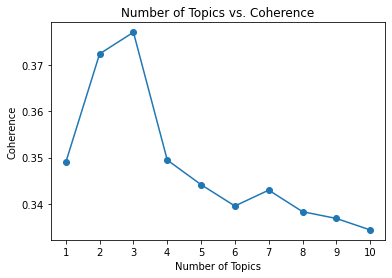

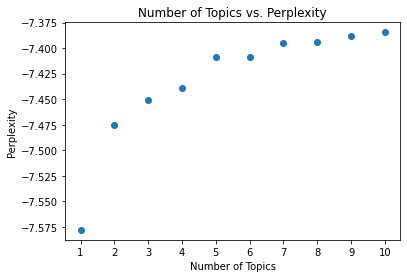

In [39]:
# change the dataset to look at here
data = df[df['popularity_dummy'] == 1]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [40]:
# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model1/ldavis_1')
LDAmodel_filepath = os.path.join('./model1/ldamodel_1')
LDAwords_filepath = os.path.join('./model1/ldawords_1')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model1/ldamodel_1' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"cause" + 0.009*"bitch" + 0.009*"man" + 0.007*"shit" + 0.007*"time" + '
  '0.007*"girl" + 0.006*"rock" + 0.006*"nigga" + 0.006*"niggas" + 0.005*"way"'),
 (1,
  '0.037*"love" + 0.021*"way" + 0.021*"time" + 0.016*"heart" + 0.016*"life" + '
  '0.014*"day" + 0.013*"world" + 0.012*"cause" + 0.012*"man" + 0.011*"eye"'),
 (2,
  '0.035*"baby" + 0.024*"night" + 0.023*"time" + 0.013*"girl" + 0.010*"thing" '
  '+ 0.010*"day" + 0.009*"yeah" + 0.009*"gon" + 0.009*"cause" + 0.008*"mind"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.086316  0.056842       1        1  42.479632
0      0.124284  0.016938       2        1  33.602597
2     -0.037968 -0.073780       3        1  23.917771, topic_info=      Term          Freq         Total Category  logprob  loglift
225   baby  22141.000000  22141.000000  Default  30.0000  30.0000
249   love  29400.000000  29400.000000  Default  29.0000  29.0000
133  night  15972.000000  15972.000000  Default  28.0000  28.0000
303  heart  13434.000000  13434.000000  Default  27.0000  27.0000
338  bitch   5448.000000   5448.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
265    sun   1444.482969   4000.105335   Topic3  -5.6300   0.4120
249   love   1902.702350  29400.525561   Topic3  -5.3545  -1.3072
11    hand   1579.545536   7942.469240   Topic3  -5.5406  -0.1845
303  heart   1549.088809  13434.016401   Topic3  -5.5601  -0.7296
129    eye   1453.574561  10268.558713   Topic3  -5.6237  -0.5245

[303 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
3139       1  0.926869  affair
3139       2  0.032470  affair
3139       3  0.041325  affair
300        1  0.830238      ah
300        2  0.058325      ah
...      ...       ...     ...
413        1  0.055744      yo
413        2  0.900321      yo
413        3  0.043824      yo
9605       1  0.972853     yoy
11970      2  0.984202     zen

[598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [41]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model1/stylecloud_1_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1930 and 1940

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


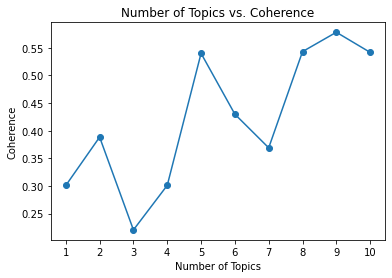

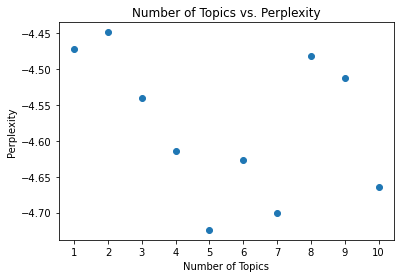

In [9]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1930) & (df['year'] < 1940)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [12]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model2/ldavis_2')
LDAmodel_filepath = os.path.join('./model2/ldamodel_2')
LDAwords_filepath = os.path.join('./model2/ldawords_2')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model2/ldamodel_2' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.012*"arm" + 0.012*"charm" + 0.012*"trick" + 0.012*"gate" + 0.012*"heart" '
  '+ 0.012*"thrill" + 0.012*"hurry" + 0.012*"start" + 0.012*"fella" + '
  '0.012*"whoa"'),
 (1,
  '0.048*"heart" + 0.048*"thrill" + 0.048*"trick" + 0.048*"arm" + 0.048*"gate" '
  '+ 0.048*"charm" + 0.026*"whoa" + 0.026*"get" + 0.026*"door" + 0.026*"come"'),
 (2,
  '0.094*"heart" + 0.061*"dream" + 0.054*"love" + 0.035*"please" + '
  '0.028*"mornin" + 0.028*"singin" + 0.021*"daddy" + 0.021*"storm" + '
  '0.021*"song" + 0.021*"someone"'),
 (3,
  '0.012*"heart" + 0.012*"love" + 0.012*"wind" + 0.012*"snow" + 0.012*"glove" '
  '+ 0.012*"december" + 0.012*"icicle" + 0.012*"place" + 0.012*"flame" + '
  '0.012*"life"'),
 (4,
  '0.012*"heart" + 0.012*"love" + 0.012*"snow" + 0.012*"wind" + '
  '0.012*"december" + 0.012*"glove" + 0.012*"storm" + 0.012*"fire" + '
  '0.012*"place" + 0.012*"life"')]


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.144654  0.0       1        1  79.961294
1      0.147739  0.0       2        1  17.908230
0     -0.000931  0.0       3        1   0.710159
3     -0.001077 -0.0       4        1   0.710159
4     -0.001077  0.0       5        1   0.710159, topic_info=       Term      Freq     Total Category  logprob  loglift
2     dream  8.000000  8.000000  Default  30.0000  30.0000
5      love  7.000000  7.000000  Default  29.0000  29.0000
6    please  4.000000  4.000000  Default  28.0000  28.0000
7    singin  3.000000  3.000000  Default  27.0000  27.0000
43   mornin  3.000000  3.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
76     hope  0.013947  2.073087   Topic5  -4.4188  -0.0541
82     pray  0.013947  2.073244   Topic5  -4.4188  -0.0542
29  someone  0.013947  2.938609   Topic5  -4.4188  -0.4030
45      sky  0.013947  2.073514   Topic5  -4.4188  -0.0543
35     baby  0.013947  1.208252   Topic5  -4.4188   0.4857

[233 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
50        2  0.615407     arm
35        1  0.827642    baby
51        2  1.016133    back
52        2  1.016293    band
0         1  0.964545  borrow
...     ...       ...     ...
32        1  1.020947     way
71        2  1.016337    whoa
19        1  0.827648    wind
10        1  0.964544  window
49        1  0.964545    wing

[76 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

In [13]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model2/stylecloud_2_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1940 and 1950

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


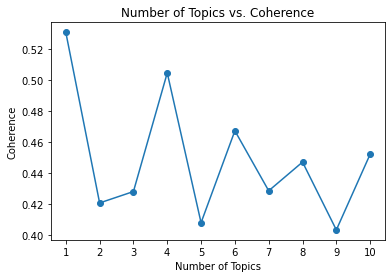

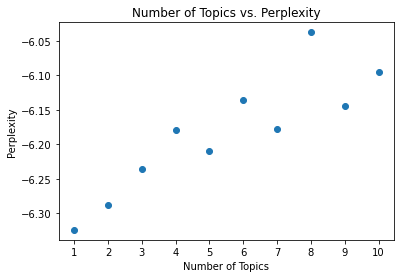

In [14]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1940) & (df['year'] < 1950)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [15]:
# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model3/ldavis_3')
LDAmodel_filepath = os.path.join('./model3/ldamodel_3')
LDAwords_filepath = os.path.join('./model3/ldawords_3')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model3/ldamodel_3' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.025*"doin" + 0.015*"learnin" + 0.015*"love" + 0.015*"folk" + '
  '0.015*"brooklyn" + 0.013*"school" + 0.013*"bridge" + 0.011*"book" + '
  '0.009*"face" + 0.009*"thing"'),
 (1,
  '0.033*"reindeer" + 0.027*"road" + 0.016*"blue" + 0.016*"rule" + '
  '0.013*"people" + 0.013*"body" + 0.013*"nose" + 0.010*"book" + 0.010*"world" '
  '+ 0.010*"house"'),
 (2,
  '0.041*"man" + 0.034*"time" + 0.029*"love" + 0.021*"gun" + 0.016*"heart" + '
  '0.013*"rainin" + 0.011*"music" + 0.011*"gu" + 0.011*"thing" + 0.011*"glad"'),
 (3,
  '0.042*"day" + 0.042*"night" + 0.013*"life" + 0.010*"moon" + 0.010*"energy" '
  '+ 0.007*"room" + 0.007*"love" + 0.007*"till" + 0.007*"sun" + '
  '0.007*"silence"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.153262  0.019902       1        1  39.294369
2     -0.024027 -0.143244       2        1  23.425537
3     -0.106909  0.044196       3        1  18.823929
1     -0.022326  0.079146       4        1  18.456164, topic_info=         Term       Freq      Total Category  logprob  loglift
147       man  11.000000  11.000000  Default  30.0000  30.0000
48      night  11.000000  11.000000  Default  29.0000  29.0000
359  reindeer   7.000000   7.000000  Default  28.0000  28.0000
12        day  12.000000  12.000000  Default  27.0000  27.0000
78       time  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
42       love   1.316846  16.031922   Topic4  -5.0104  -0.8096
32    history   1.316408   2.561342   Topic4  -5.0107   1.0241
184       way   1.316049   3.724975   Topic4  -5.0110   0.6493
145       lot   1.315124   2.562029   Topic4  -5.0117   1.0229
189    secret   1.314424   2.407833   Topic4  -5.0122   1.0844

[196 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
509       4  0.835008   america
1         1  0.253478  anything
1         2  0.760433  anything
204       2  0.397533       arm
204       3  0.397533       arm
...     ...       ...       ...
88        2  0.526415     world
88        4  0.350944     world
308       4  0.552186     wreck
303       3  0.806867   yearnin
99        2  0.780870     youth

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [16]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model3/stylecloud_3_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1950 and 1960

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


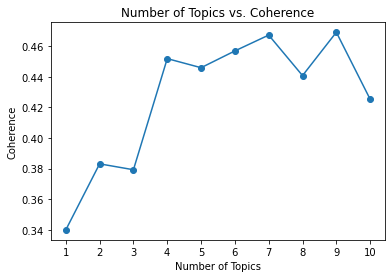

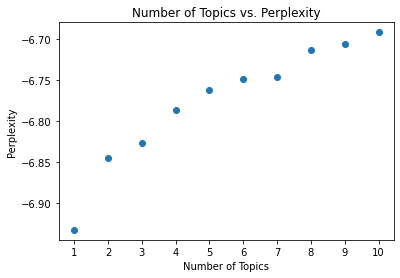

In [17]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1950) & (df['year'] < 1960)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [18]:
# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model4/ldavis_4')
LDAmodel_filepath = os.path.join('./model4/ldamodel_4')
LDAwords_filepath = os.path.join('./model4/ldawords_4')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model4/ldamodel_4' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.028*"christmas" + 0.020*"lauren" + 0.014*"claus" + 0.012*"night" + '
  '0.011*"king" + 0.010*"mess" + 0.010*"christma" + 0.009*"day" + 0.009*"cole" '
  '+ 0.009*"nat"'),
 (1,
  '0.030*"love" + 0.019*"heart" + 0.018*"time" + 0.015*"baby" + 0.013*"home" + '
  '0.012*"night" + 0.009*"hand" + 0.009*"lord" + 0.009*"rock" + 0.008*"way"'),
 (2,
  '0.022*"baby" + 0.019*"love" + 0.018*"time" + 0.012*"man" + 0.011*"head" + '
  '0.008*"day" + 0.008*"dooley" + 0.008*"part" + 0.007*"boy" + 0.007*"cry"'),
 (3,
  '0.038*"woman" + 0.029*"way" + 0.027*"banua" + 0.021*"man" + 0.014*"jane" + '
  '0.013*"life" + 0.013*"baby" + 0.012*"blue" + 0.011*"wah" + 0.010*"cause"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.045180  0.097662       1        1  29.488543
2     -0.037086  0.061652       2        1  25.287503
0      0.184439 -0.033421       3        1  24.261103
3     -0.102173 -0.125893       4        1  20.962851, topic_info=          Term       Freq      Total Category  logprob  loglift
37       woman  51.000000  51.000000  Default  30.0000  30.0000
602      banua  32.000000  32.000000  Default  29.0000  29.0000
341  christmas  43.000000  43.000000  Default  28.0000  28.0000
462     lauren  28.000000  28.000000  Default  27.0000  27.0000
36         way  53.000000  53.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
11        love   9.297927  96.028027   Topic4  -4.8490  -0.7724
210       hand   6.363474  32.580300   Topic4  -5.2282  -0.0707
83       place   4.600797   9.026568   Topic4  -5.5525   0.8885
245       head   4.600543  23.662297   Topic4  -5.5526  -0.0753
66      moment   4.600322  13.796134   Topic4  -5.5526   0.4642

[253 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
422       3  0.897324   andy
1507      2  0.868903    ann
952       4  0.964448   anno
90        1  0.450539    arm
90        2  0.386176    arm
...     ...       ...    ...
59        3  0.551089  world
156       1  0.363238   yeah
156       2  0.072648   yeah
156       3  0.072648   yeah
156       4  0.435886   yeah

[358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [19]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model4/stylecloud_4_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1960 and 1970

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


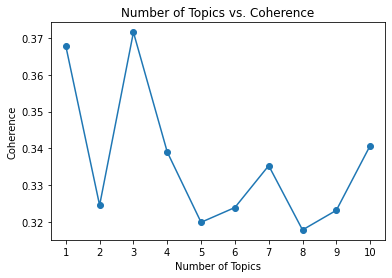

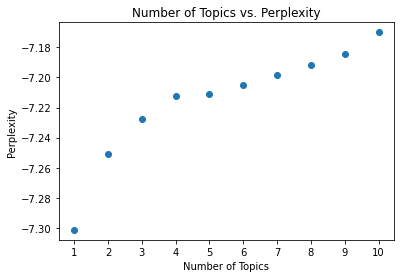

In [20]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1960) & (df['year'] < 1970)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [21]:
# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model5/ldavis_5')
LDAmodel_filepath = os.path.join('./model5/ldamodel_5')
LDAwords_filepath = os.path.join('./model5/ldawords_5')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model5/ldamodel_5' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.018*"baby" + 0.014*"man" + 0.013*"way" + 0.011*"yeah" + 0.010*"time" + '
  '0.009*"cause" + 0.009*"heart" + 0.008*"thing" + 0.008*"night" + '
  '0.006*"friend"'),
 (1,
  '0.012*"man" + 0.008*"way" + 0.008*"day" + 0.006*"rock" + 0.006*"eye" + '
  '0.006*"boy" + 0.006*"time" + 0.006*"thing" + 0.005*"hey" + 0.005*"people"'),
 (2,
  '0.049*"love" + 0.029*"baby" + 0.027*"time" + 0.020*"day" + 0.018*"heart" + '
  '0.016*"girl" + 0.015*"night" + 0.012*"way" + 0.011*"gon" + 0.011*"world"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.094284 -0.063693       1        1  47.337815
1     -0.123873 -0.026850       2        1  27.725220
0      0.029590  0.090543       3        1  24.936964, topic_info=      Term         Freq        Total Category  logprob  loglift
38    love  3033.000000  3033.000000  Default  30.0000  30.0000
149   baby  2379.000000  2379.000000  Default  29.0000  29.0000
593   rock   246.000000   246.000000  Default  28.0000  28.0000
36   heart  1410.000000  1410.000000  Default  27.0000  27.0000
181  stone   206.000000   206.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
71   world   175.632647   873.505714   Topic3  -5.1632  -0.2153
7     girl   175.204731  1190.453174   Topic3  -5.1656  -0.5273
159   life   158.820405   885.265967   Topic3  -5.2638  -0.3293
208  woman   140.551467   507.948823   Topic3  -5.3860   0.1040
53    home   139.403684   688.661559   Topic3  -5.3942  -0.2086

[253 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
31        1  0.307840         ah
31        2  0.554113         ah
31        3  0.141244         ah
3902      2  0.985309       amen
3902      3  0.020964       amen
...     ...       ...        ...
1011      1  0.912044  yesterday
1011      2  0.040002  yesterday
1011      3  0.048002  yesterday
2025      3  0.975059         yi
2738      3  0.923808      zowie

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [22]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model5/stylecloud_5_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1970 and 1980

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


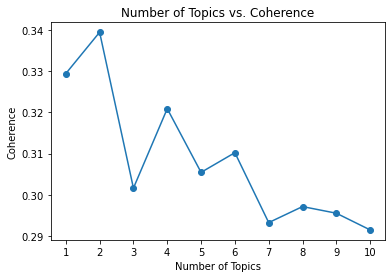

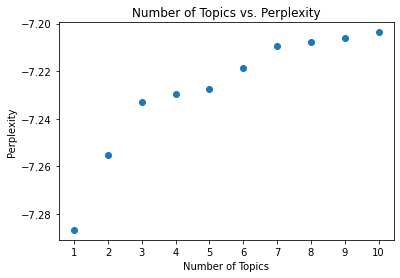

In [23]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1970) & (df['year'] < 1980)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [24]:
# number of topics
num_topics = 2

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model6/ldavis_6')
LDAmodel_filepath = os.path.join('./model6/ldamodel_6')
LDAwords_filepath = os.path.join('./model6/ldawords_6')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model6/ldamodel_6' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.036*"love" + 0.022*"man" + 0.010*"girl" + 0.008*"heart" + 0.008*"dream" + '
  '0.007*"world" + 0.007*"way" + 0.007*"doo" + 0.006*"people" + 0.006*"hand"'),
 (1,
  '0.027*"time" + 0.022*"baby" + 0.019*"way" + 0.017*"day" + 0.017*"night" + '
  '0.012*"life" + 0.011*"love" + 0.011*"gon" + 0.011*"thing" + 0.009*"cause"')]


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.071958  0.0       1        1  61.840466
0     -0.071958  0.0       2        1  38.159534, topic_info=       Term         Freq        Total Category  logprob  loglift
56     love  5512.000000  5512.000000  Default  30.0000  30.0000
13      man  3354.000000  3354.000000  Default  29.0000  29.0000
1217    doo   678.000000   678.000000  Default  28.0000  28.0000
25     baby  4096.000000  4096.000000  Default  27.0000  27.0000
21     time  4942.000000  4942.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
35      day   479.632400  3200.926753   Topic2  -5.3531  -0.9348
62    night   464.941589  3184.090872   Topic2  -5.3842  -0.9606
122   woman   371.247009  1403.287380   Topic2  -5.6093  -0.3663
25     baby   403.942134  4096.515739   Topic2  -5.5249  -1.3532
47      gon   353.487398  2182.945048   Topic2  -5.6583  -0.8572

[200 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
540       1  0.508711     ah
540       2  0.491169     ah
7195      2  0.996293   ahoy
2829      1  0.028274    ann
2829      2  0.989582    ann
...     ...       ...    ...
225       2  0.446497  world
134       1  0.738014   yeah
134       2  0.262017   yeah
1434      1  0.065974     yo
1434      2  0.931885     yo

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model6/stylecloud_6_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1980 and 1990

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


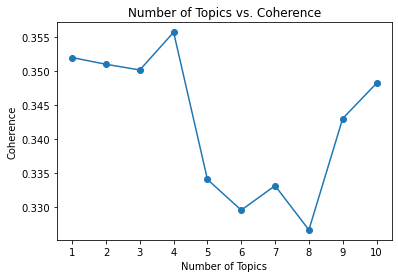

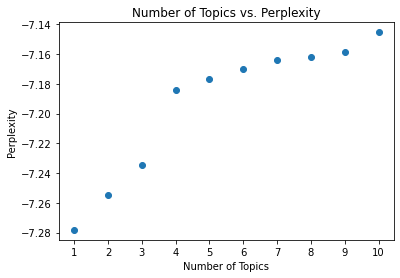

In [26]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1980) & (df['year'] < 1990)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [28]:
# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model7/ldavis_7')
LDAmodel_filepath = os.path.join('./model7/ldamodel_7')
LDAwords_filepath = os.path.join('./model7/ldawords_7')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model7/ldamodel_7' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.033*"baby" + 0.019*"girl" + 0.016*"way" + 0.013*"hey" + 0.013*"ooh" + '
  '0.011*"thing" + 0.011*"yeah" + 0.009*"time" + 0.008*"eye" + 0.007*"life"'),
 (1,
  '0.021*"night" + 0.018*"heart" + 0.015*"gon" + 0.014*"man" + 0.012*"way" + '
  '0.012*"world" + 0.011*"day" + 0.011*"time" + 0.010*"life" + 0.008*"cause"'),
 (2,
  '0.059*"love" + 0.034*"time" + 0.014*"baby" + 0.012*"night" + 0.012*"eye" + '
  '0.011*"day" + 0.011*"thing" + 0.011*"way" + 0.010*"one" + 0.010*"cause"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.054719  0.065505       1        1  38.050751
1     -0.041098 -0.072021       2        1  36.565678
0      0.095817  0.006517       3        1  25.383572, topic_info=      Term         Freq        Total Category  logprob  loglift
167   love  7784.000000  7784.000000  Default  30.0000  30.0000
148   baby  4343.000000  4343.000000  Default  29.0000  29.0000
144    ooh  1094.000000  1094.000000  Default  28.0000  28.0000
193   girl  2711.000000  2711.000000  Default  27.0000  27.0000
208    hey  1414.000000  1414.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
252   head   302.210204   967.089001   Topic3  -5.4920   0.2079
68   world   367.857033  2298.859407   Topic3  -5.2954  -0.4614
167   love   470.053491  7784.654778   Topic3  -5.0503  -1.4360
26   night   402.405590  3942.321261   Topic3  -5.2057  -0.9110
74     day   376.439516  2777.882034   Topic3  -5.2724  -0.6276

[281 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3159      1  0.018061     aah
3159      3  0.975294     aah
528       1  0.100944      ah
528       2  0.173718      ah
528       3  0.725391      ah
...     ...       ...     ...
115       2  0.296558    year
115       3  0.091121    year
3221      3  0.985211     yoy
915       2  0.992241  yvette
4527      3  0.989094    zoid

[485 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [29]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model7/stylecloud_7_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 1990 and 2000

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


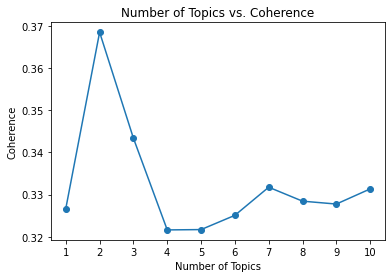

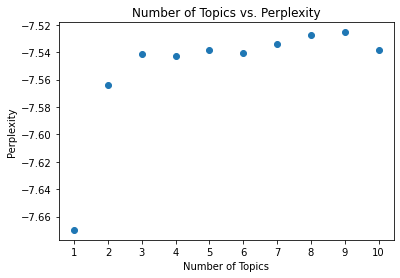

In [30]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 1990) & (df['year'] < 2000)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [31]:
# number of topics
num_topics = 2

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model8/ldavis_8')
LDAmodel_filepath = os.path.join('./model8/ldamodel_8')
LDAwords_filepath = os.path.join('./model8/ldawords_8')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model8/ldamodel_8' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"man" + 0.011*"cause" + 0.008*"time" + 0.008*"shit" + 0.008*"niggas" '
  '+ 0.007*"nigga" + 0.007*"yo" + 0.007*"bitch" + 0.006*"day" + 0.006*"ass"'),
 (1,
  '0.027*"love" + 0.021*"time" + 0.021*"baby" + 0.016*"way" + 0.012*"cause" + '
  '0.012*"thing" + 0.012*"night" + 0.011*"day" + 0.011*"heart" + 0.011*"girl"')]


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.088771  0.0       1        1  50.278214
0     -0.088771  0.0       2        1  49.721786, topic_info=       Term         Freq        Total Category  logprob  loglift
150    love  5768.000000  5768.000000  Default  30.0000  30.0000
69     baby  4684.000000  4684.000000  Default  29.0000  29.0000
75    heart  2483.000000  2483.000000  Default  28.0000  28.0000
53     girl  2483.000000  2483.000000  Default  27.0000  27.0000
902  niggas  1645.000000  1645.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
124    word   557.687119  1285.728282   Topic2  -5.9050  -0.1366
99      eye   623.770414  2184.739906   Topic2  -5.7930  -0.5547
152    mind   593.230022  1953.175801   Topic2  -5.8432  -0.4929
25     yeah   614.164156  2443.217512   Topic2  -5.8085  -0.6821
64    thing   590.856550  3005.252837   Topic2  -5.8472  -0.9278

[207 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3          1  0.920082  anything
3          2  0.079680  anything
2788       1  0.970602   anytime
2788       2  0.046219   anytime
12254      1  0.021000  applebum
...      ...       ...       ...
928        2  0.902675        yo
87         1  0.989917    yonder
87         2  0.036664    yonder
2507       1  0.021009    zombie
2507       2  0.987420    zombie

[324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [32]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model8/stylecloud_8_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 2000 and 2010

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


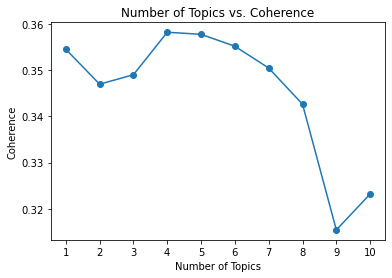

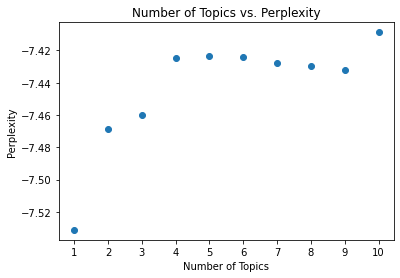

In [33]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 2000) & (df['year'] < 2010)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [34]:
# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model9/ldavis_9')
LDAmodel_filepath = os.path.join('./model9/ldamodel_9')
LDAwords_filepath = os.path.join('./model9/ldawords_9')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model9/ldamodel_9' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.022*"time" + 0.013*"everything" + 0.011*"man" + 0.010*"la" + '
  '0.009*"night" + 0.007*"day" + 0.007*"song" + 0.006*"fire" + 0.006*"mind" + '
  '0.006*"oh"'),
 (1,
  '0.030*"way" + 0.025*"cause" + 0.023*"love" + 0.022*"life" + 0.019*"time" + '
  '0.015*"girl" + 0.010*"world" + 0.009*"thing" + 0.009*"nothing" + '
  '0.008*"eye"'),
 (2,
  '0.021*"baby" + 0.018*"time" + 0.018*"day" + 0.016*"thing" + 0.014*"heart" + '
  '0.013*"love" + 0.011*"night" + 0.011*"hey" + 0.011*"gon" + 0.010*"cause"'),
 (3,
  '0.013*"bitch" + 0.010*"cause" + 0.010*"girl" + 0.010*"shit" + 0.009*"ass" + '
  '0.009*"man" + 0.007*"nigga" + 0.007*"niggas" + 0.007*"fuck" + 0.007*"em"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.075734 -0.035179       1        1  34.066774
3      0.156098 -0.035640       2        1  28.824348
1     -0.073694 -0.050303       3        1  24.395872
0     -0.006671  0.121123       4        1  12.713007, topic_info=           Term         Freq        Total Category  logprob  loglift
204         way  3453.000000  3453.000000  Default  30.0000  30.0000
137        love  3074.000000  3074.000000  Default  29.0000  29.0000
13         time  4338.000000  4338.000000  Default  28.0000  28.0000
263       bitch  1114.000000  1114.000000  Default  27.0000  27.0000
169  everything  1328.000000  1328.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
58       people   115.378433   851.990824   Topic4  -5.7442   0.0632
204         way   124.337253  3453.249749   Topic4  -5.6694  -1.2615
137        love   120.875742  3074.726157   Topic4  -5.6977  -1.1737
220        baby   115.173567  2781.733054   Topic4  -5.7460  -1.1218
82         yeah   111.225120  1642.692121   Topic4  -5.7809  -0.6300

[348 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11087      4  0.952387  advertising
11540      4  0.977123   alcohaulin
3177       2  0.165446      alcohol
3177       3  0.827230      alcohol
5871       3  0.969248        aloud
...      ...       ...          ...
967        1  0.070342           yo
967        2  0.863119           yo
967        3  0.034221           yo
967        4  0.034221           yo
5148       2  0.987805         zoom

[726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [35]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model9/stylecloud_9_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# For songs between 2010 and now

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


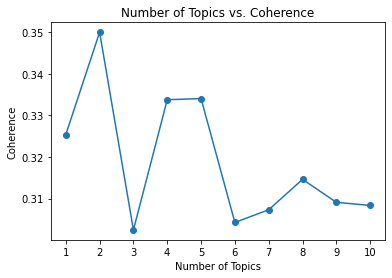

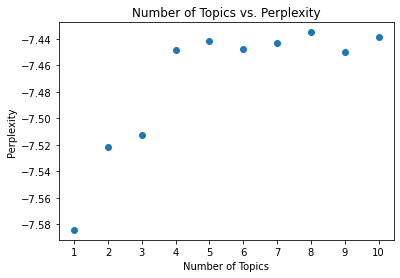

In [36]:
# change the dataset to look at here
data = df[(df['popularity_dummy'] == 1) & (df['year'] >= 2010)]['lyrics'].values.tolist()

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

coherence = []
perplexity = []

best_cm_model = None
best_coherence = 0
best_perplex = 0
best_perplex_model = None

for k in range(1,11):
    print('Round: '+ str(k))
    ldamodel = gensim.models.LdaMulticore(corpus, num_topics=k, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,\
                                                     dictionary=id2word, coherence='c_v', processes = -1)
    
    perplex_score = ldamodel.log_perplexity(corpus)
    
    if cm.get_coherence() > best_coherence:
        best_coherence = cm.get_coherence()
        best_cm_model = ldamodel
        
    if perplex_score > best_perplex:
        best_perplex = perplex_score
        best_perplex_model = ldamodel
        
    coherence.append((k,cm.get_coherence()))
    perplexity.append((k, perplex_score))
    
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

x_val = [x[0] for x in perplexity]
y_val = [x[1] for x in perplexity]

plt.figure()
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_val)
plt.show()

In [37]:
# number of topics
num_topics = 2

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word = id2word, random_state = 100,\
                                          chunksize = 30000, passes = 10)

# print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./model10/ldavis_10')
LDAmodel_filepath = os.path.join('./model10/ldamodel_10')
LDAwords_filepath = os.path.join('./model10/ldawords_10')

# Store the top words

topic_words = []

for i in range(num_topics):
    
    tt = lda_model.get_topic_terms(i, 20)
    topic_words.append([id2word[pair[0]] for pair in tt])

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAmodel_filepath, 'wb') as f:
        pickle.dump(lda_model, f)
        
    with open(LDAwords_filepath, 'wb') as f:
        pickle.dump(topic_words, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './model10/ldamodel_10' +'.html')
LDAvis_prepared

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.022*"love" + 0.017*"baby" + 0.013*"girl" + 0.013*"time" + 0.012*"life" + '
  '0.011*"heart" + 0.011*"cause" + 0.010*"night" + 0.009*"world" + '
  '0.008*"gon"'),
 (1,
  '0.014*"way" + 0.014*"cause" + 0.014*"time" + 0.012*"bitch" + 0.010*"yeah" + '
  '0.009*"man" + 0.008*"shit" + 0.008*"day" + 0.008*"night" + 0.008*"baby"')]


PreparedData(topic_coordinates=              x    y  topics  cluster     Freq
topic                                         
1      0.071555  0.0       1        1  55.0366
0     -0.071555  0.0       2        1  44.9634, topic_info=           Term         Freq        Total Category  logprob  loglift
191        love  3481.000000  3481.000000  Default  30.0000  30.0000
75        bitch  2096.000000  2096.000000  Default  29.0000  29.0000
262        feat  1099.000000  1099.000000  Default  28.0000  28.0000
308       nigga  1074.000000  1074.000000  Default  27.0000  27.0000
53         shit  1418.000000  1418.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
68         yeah   872.161421  2617.524204   Topic2  -5.0527  -0.2997
173  everything   615.706332  1278.279670   Topic2  -5.4009   0.0688
405         way   780.265025  3187.315570   Topic2  -5.1640  -0.6080
397        hand   554.429975  1276.194984   Topic2  -5.5057  -0.0344
57         song   538.021472   980.280790   Topic2  -5.5358   0.1994

[196 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1886      1  0.019459  ariana
1886      2  0.972940  ariana
4         1  0.905364     ass
4         2  0.094309     ass
2079      1  0.990305   award
...     ...       ...     ...
68        2  0.333139    yeah
3011      1  0.985946     yuh
3011      2  0.020121     yuh
4245      1  0.031253    zara
4245      2  0.968843    zara

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [38]:
for i in range(num_topics):
    
    words = ' '.join(topic_words[i])

    stylecloud.gen_stylecloud(text = words,
        size = 2048,
        icon_name='fas fa-music',
        stopwords = True,
        max_words = 300,
        output_name = "model10/stylecloud_10_topic{}.png".format(i)
    )

C:\Users\spiky\anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Things to work on:

1. For each decade, identify topics and assign a dummy variable for it.

2. For each decade, visualise the key topics observed and see how that has changed.